In [ ]:
import os
import gc
import ast 
import random
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torchaudio
import IPython.display as ipd
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score

import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from typing import List

import warnings
warnings.filterwarnings('ignore')

In [ ]:
class config:
    seed=2022
    num_fold = 5
    sample_rate= 32_000
    n_fft=1024
    hop_length=512
    n_mels=64
    duration=7
    num_classes = 152
    train_batch_size = 32
    valid_batch_size = 64
    model_name = 'resnet50'
    epochs = 2
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    learning_rate = 1e-4

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(config.seed)

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/project/train_metadata.csv')
train_df.head(50)

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,time,url,filename
0,afrsil1,[],"['call', 'flight call']",12.3910,-1.4930,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,2.5,08:00,https://www.xeno-canto.org/125458,afrsil1/XC125458.ogg
1,afrsil1,"['houspa', 'redava', 'zebdov']",['call'],19.8801,-155.7254,Euodice cantans,African Silverbill,Dan Lane,Creative Commons Attribution-NonCommercial-Sha...,3.5,08:30,https://www.xeno-canto.org/175522,afrsil1/XC175522.ogg
2,afrsil1,[],"['call', 'song']",16.2901,-16.0321,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:30,https://www.xeno-canto.org/177993,afrsil1/XC177993.ogg
3,afrsil1,[],"['alarm call', 'call']",17.0922,54.2958,Euodice cantans,African Silverbill,Oscar Campbell,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:00,https://www.xeno-canto.org/205893,afrsil1/XC205893.ogg
4,afrsil1,[],['flight call'],21.4581,-157.7252,Euodice cantans,African Silverbill,Ross Gallardy,Creative Commons Attribution-NonCommercial-Sha...,3.0,16:30,https://www.xeno-canto.org/207431,afrsil1/XC207431.ogg
5,afrsil1,[],['flight call'],21.4581,-157.7252,Euodice cantans,African Silverbill,Ross Gallardy,Creative Commons Attribution-NonCommercial-Sha...,4.0,16:30,https://www.xeno-canto.org/207432,afrsil1/XC207432.ogg
6,afrsil1,[],['call'],21.3561,-158.0205,Euodice cantans,African Silverbill,Ross Gallardy,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:00,https://www.xeno-canto.org/209513,afrsil1/XC209513.ogg
7,afrsil1,[],"['flight call', 'traffic']",10.1538,-0.7996,Euodice cantans,African Silverbill,Phil Gregory,Creative Commons Attribution-NonCommercial-Sha...,3.0,09:00,https://www.xeno-canto.org/234994,afrsil1/XC234994.ogg
8,afrsil1,[],['call'],14.5088,-17.0696,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,3.5,08:00,https://www.xeno-canto.org/317039,afrsil1/XC317039.ogg
9,afrsil1,[],['call'],14.7279,-17.4329,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,3.5,10:30,https://www.xeno-canto.org/322742,afrsil1/XC322742.ogg


In [ ]:
arr = os.listdir('/content/drive/MyDrive/project/train_audio')
print(arr)

['saffin', 'afrsil1', 'bubsan']


In [ ]:
flag = 0
for i in range(0,len(train_df)):
  for j in range(0,len(arr)):
    if train_df['primary_label'][i] != arr[j]:
      flag = 1
    else:
      flag = 0 
      break
  if flag == 1:
    train_df.drop(i,axis=0,inplace=True)
    flag = 0

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3939 entries, 0 to 12891
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   primary_label     3939 non-null   object 
 1   secondary_labels  3939 non-null   object 
 2   type              3939 non-null   object 
 3   latitude          3939 non-null   float64
 4   longitude         3939 non-null   float64
 5   scientific_name   3939 non-null   object 
 6   common_name       3939 non-null   object 
 7   author            3939 non-null   object 
 8   license           3939 non-null   object 
 9   rating            3939 non-null   float64
 10  time              3939 non-null   object 
 11  url               3939 non-null   object 
 12  filename          3939 non-null   object 
dtypes: float64(3), object(10)
memory usage: 430.8+ KB


In [ ]:
train_df.describe()

,latitude,longitude,rating
count,3939.000000,3939.000000,3939.000000
mean,34.353811,-55.616085,3.790302
std,21.628146,65.168729,1.121638
min,-44.346700,-176.177500,0.000000
25%,27.783400,-109.003300,3.500000
50%,37.190500,-76.531000,4.000000
75%,48.823650,1.204000,4.500000
max,78.342300,179.338100,5.000000


In [ ]:
filename_1 = train_df["filename"].values[2] 
ipd.Audio(f"/content/drive/MyDrive/project/train_audio/{filename_1}")

In [ ]:
class Dataviz():
    def __init__(self, root_dir, train_dff):
        self.root_dir = root_dir
        self.train_df = train_dff
    
    
    def feature_distribution(self, feature: str):
        plt.figure(figsize=(20, 6))

        sns.countplot(self.train_df[feature])
        plt.xticks(rotation=90)
        plt.title(f"Distribution of {feature} Labels", fontsize=20)

        plt.show()
        
    
    def most_common(self, feature: str, k: int):
        
        if isinstance(self.train_df[feature].iloc[0], list):
    
            top = Counter([typ.lower() for lst in self.train_df[feature] 
                                           for typ in lst])

            top = dict(top.most_common(k))

            plt.figure(figsize=(20, 6))

            sns.barplot(x=list(top.keys()), y=list(top.values()), palette='hls')
            plt.title(f"Top {k} song {feature}")
            
        else:
            top = Counter([f.lower() for f in self.train_df[feature]])

            top = dict(top.most_common(k))

            plt.figure(figsize=(20, 6))

            sns.barplot(x=list(top.keys()), y=list(top.values()), palette='hls')
            plt.title(f"Top {k} song {feature}")

        plt.show()
            
    
    
    def waveform(self, indices: List[str]):
        if isinstance(indices, int):
            indices = [indices]
        n = len(indices)
                                  
        if n == 1:    
            idx = indices[0]
            fig, ax = plt.subplots(1, 1, figsize=(20, 5))
            fig.suptitle("Sound Waves", fontsize=15)
            
            signal_1, sample_rate = torchaudio.load(f"{self.root_dir}/train_audio/{self.train_df.filename.iloc[idx]}")
           
            sns.lineplot(x=np.arange(len(signal_1[0,:].detach().numpy())), y=signal_1[0,:].detach().numpy(), ax=ax, color='#4400FF')
            ax.set_title(f"Audio {idx}")
        
        elif n > 1:
            fig, ax = plt.subplots(n, 1, figsize=(20, 5 * n))
            fig.suptitle("Sound Waves", fontsize=15)
            
            for i, idx in enumerate(indices):

                signal, sample_rate = torchaudio.load(f"{self.root_dir}/train_audio/{self.train_df.filename.iloc[idx]}")
           
                sns.lineplot(x=np.arange(len(signal[0,:].detach().numpy())), y=signal[0,:].detach().numpy(), ax=ax[i], color='#4400FF')
                ax[i].set_title(f"Audio {idx}")

        else:
            print("n should be more than or equal to 1")
            assert n >= 1
            
        plt.show()

In [ ]:
train_viz = Dataviz('/content/drive/MyDrive/project', train_df)

In [ ]:
len(train_df['primary_label'].unique()) == len(arr)

True

In [ ]:
train_df.primary_label.unique()

array(['afrsil1', 'bubsan', 'saffin'], dtype=object)

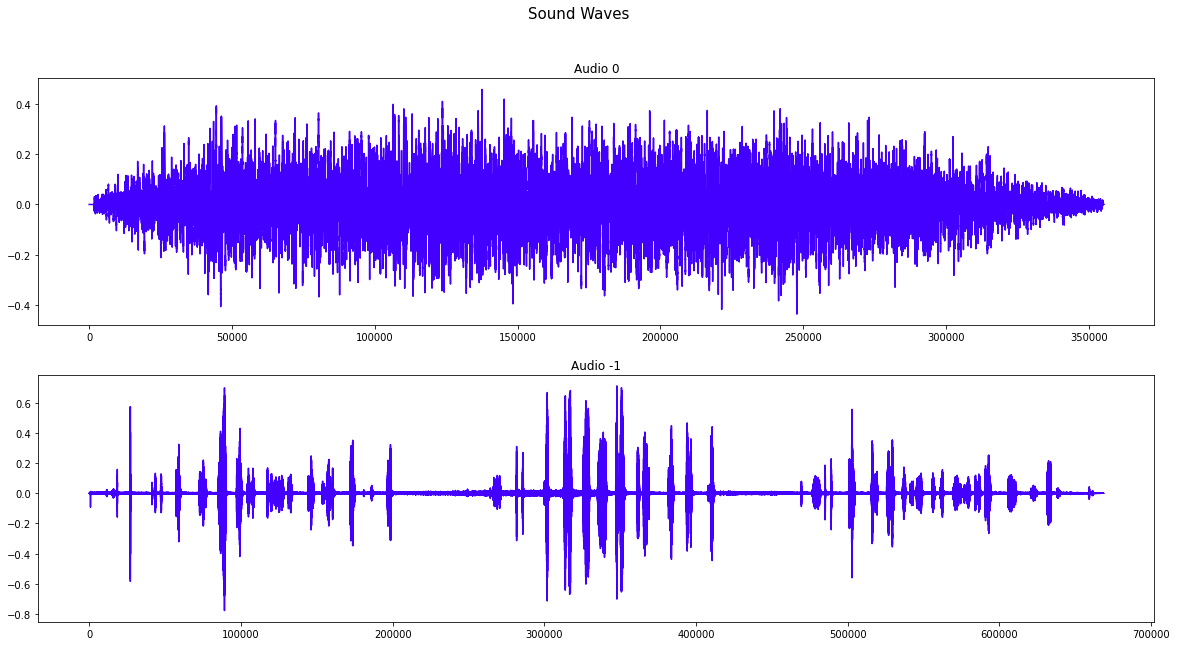

In [ ]:
train_viz.waveform([0,-1])

In [ ]:
class Dataviz():
    def __init__(self, sample_rate, n_fft, hop_length, n_mels, train_dff):
        self.root_dir = '/content/drive/MyDrive/project'
        self.sample_rate = sample_rate
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.train_df = train_dff
        self.mel_converter = torchaudio.transforms.MelSpectrogram(sample_rate=self.sample_rate, 
                                                              n_fft=self.n_fft, 
                                                              hop_length=self.hop_length, 
                                                              n_mels=self.n_mels)
                
    
    def mel_spectrogram(self, indices: List[str]):
        
        if isinstance(indices, int):
            indices = [indices]
            
        n = len(indices)
                                  
        if n == 1:    
            idx = indices[0]
            fig, ax = plt.subplots(1, 1, figsize=(10, 7))
            fig.suptitle("Mel Spectrogram", fontsize=15)
            
            signal, sample_rate = torchaudio.load(f"{self.root_dir}/train_audio/{self.train_df.filename.iloc[idx]}")
            
            
            mel = self.mel_converter(signal)

            ax.imshow(mel.log2()[0,:,:].detach().numpy(), aspect='auto', cmap='cool')
            ax.set_title(f"Audio {idx}")
                    
        elif n > 1:
            fig, ax = plt.subplots(n, 1, figsize=(10,  7 * n))
            fig.suptitle("Mel Spectrogram", fontsize=15)
            
            for i, idx in enumerate(indices):

                signal, sample_rate = torchaudio.load(f"{self.root_dir}/train_audio/{self.train_df.filename.iloc[idx]}")
            

                mel = self.mel_converter(signal)
                ax[i].imshow(mel.log2()[0,:,:].detach().numpy(), aspect='auto', cmap='cool')
                ax[i].set_title(f"Audio {idx}")

        else:
            print("n should be more than or equal to 1")
            assert n >= 1
            
        plt.show()

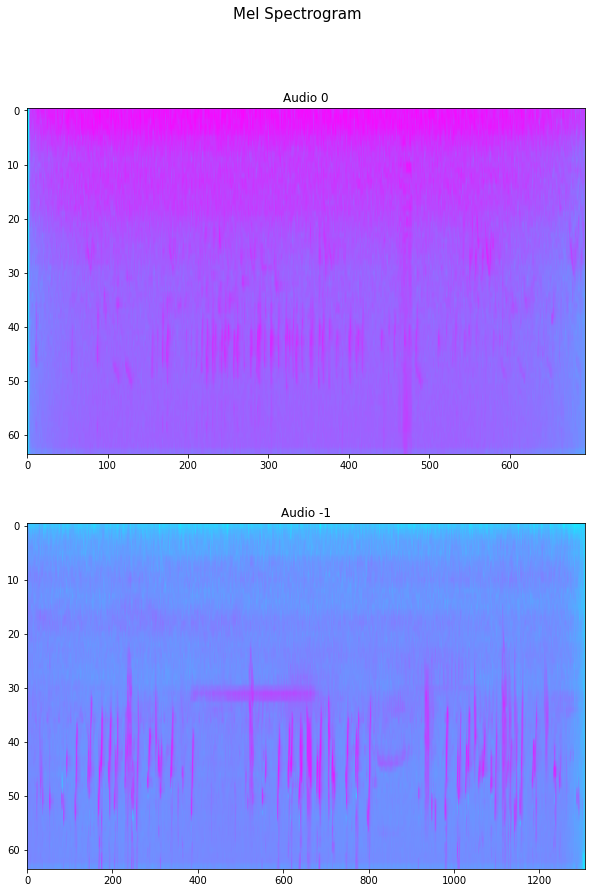

In [ ]:
train_viz = Dataviz(config.sample_rate, config.n_fft, config.hop_length, config.n_mels,train_df)
train_viz.mel_spectrogram([0, -1])

In [ ]:
class BirdClefDataset(Dataset, Dataviz):
    
    def __init__(self, df, sample_rate, n_fft, hop_length, n_mels, duration):
        self.df = df
        self.root_dir = '/content/drive/MyDrive/project'
        
        
        self.audio_paths = self.root_dir + "/" + "train_audio" + "/" + self.df.filename.values
        self.labels = self.df.primary_label_encoded.values
        
        self.sample_rate = sample_rate
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.num_samples = sample_rate * duration
        
        self.mel_converter = torchaudio.transforms.MelSpectrogram(sample_rate=self.sample_rate, 
                                                              n_fft=self.n_fft, 
                                                              hop_length=self.hop_length, 
                                                              n_mels=self.n_mels)
        
    def __len__(self):
        return len(self.audio_paths)
    
    
    def __getitem__(self, idx):
        audio_path = self.audio_paths[idx]
        signal, sample_rate = torchaudio.load(audio_path) # loaded the audio
        
   
        if sample_rate != self.sample_rate:
            resampler = torchaudio.transforms.Resample(sample_rate, self.sample_rate)
            signal = resampler(signal)
        
       
        if signal.shape[0]>1:
            signal = torch.mean(signal, axis=0, keepdim=True)
        
        
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        
        if signal.shape[1] < self.num_samples:
            num_missing_samples = self.num_samples - signal.shape[1]
            last_dim_padding = (0, num_missing_samples)
            signal = F.pad(signal, last_dim_padding)
        
        
        mel = self.mel_converter(signal)
        

        image = torch.cat([mel, mel, mel])
        
  
        max_val = torch.abs(image).max()
        image = image / max_val
        
        label = torch.tensor(self.labels[idx])
        
        return image, label

In [ ]:
from sklearn.model_selection import train_test_split
encoder = LabelEncoder()
train_df['primary_label_encoded'] = encoder.fit_transform(train_df['primary_label'])

train_df['fold']  = 0


skf = StratifiedKFold(n_splits=config.num_fold)
for k, (_, val_ind) in enumerate(skf.split(X=train_df, y=train_df['primary_label_encoded'])):
   train_df['fold'].iloc[val_ind] = k


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_df, train_df['primary_label_encoded'], test_size=0.3, random_state=2022 )


In [ ]:
X_train.columns

Index(['primary_label', 'secondary_labels', 'type', 'latitude', 'longitude',
       'scientific_name', 'common_name', 'author', 'license', 'rating', 'time',
       'url', 'filename', 'primary_label_encoded', 'fold'],
      dtype='object')

In [ ]:
def get_data(df, fold):
  
    train_df = df[df['fold'] != fold].reset_index(drop=True)
    valid_df = df[df['fold'] == fold].reset_index(drop=True)
    train_dataset = BirdClefDataset(train_df, sample_rate=config.sample_rate, n_fft=config.n_fft, hop_length=config.hop_length, n_mels=config.n_mels, duration=config.duration)
    valid_dataset = BirdClefDataset(valid_df, sample_rate=config.sample_rate, n_fft=config.n_fft, hop_length=config.hop_length, n_mels=config.n_mels, duration=config.duration)
    
    train_loader = DataLoader(train_dataset, batch_size=config.train_batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=config.valid_batch_size, shuffle=False)
    
    return train_loader, valid_loader

In [ ]:
class BirdCLEFResnet(nn.Module):
    def __init__(self):
        super(BirdCLEFResnet, self).__init__()
        self.base_model = models.__getattribute__(config.model_name)(pretrained=True)
        for param in self.base_model.parameters():
            param.requires_grad = False
            
        in_features = self.base_model.fc.in_features
        
        self.base_model.fc = nn.Sequential(
            nn.Linear(in_features, 1024), 
            nn.ReLU(), 
            nn.Dropout(p=0.2),
            nn.Linear(1024, 512), 
            nn.ReLU(), 
            nn.Dropout(p=0.2),
            nn.Linear(512, config.num_classes))
        
    def forward(self, x):
        x = self.base_model(x)
        return x

In [ ]:
def loss_fn(outputs, labels):
    return nn.CrossEntropyLoss()(outputs, labels)

def train(model, data_loader, optimizer, scheduler, device, epoch):
    model.train()
    
    running_loss = 0
    loop = tqdm(data_loader, position=0)
    for i, (mels, labels) in enumerate(loop):
        mels = mels.to(device)
        labels = labels.to(device)
        
        outputs = model(mels)
        _, preds = torch.max(outputs, 1)
        
        loss = loss_fn(outputs, labels)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if scheduler is not None:
            scheduler.step()
            
        running_loss += loss.item()
        
        loop.set_description(f"Epoch [{epoch+1}/{config.epochs}]")
        loop.set_postfix(loss=loss.item())

    return running_loss/len(data_loader)



In [ ]:
def valid(model, data_loader, device, epoch):
    model.eval()
    
   
    running_loss = 0
    pred = []
    label = []
    
    loop = tqdm(data_loader, position=0)
    for mels, labels in loop:
        mels = mels.to(device)
        labels = labels.to(device)
        
        outputs = model(mels)
        _, preds = torch.max(outputs, 1)
        
        loss = loss_fn(outputs, labels)
            
        running_loss += loss.item()
        
        pred.extend(preds.view(-1).cpu().detach().numpy())
        label.extend(labels.view(-1).cpu().detach().numpy())
        
        loop.set_description(f"Epoch [{epoch+1}/{config.epochs}]")
        loop.set_postfix(loss=loss.item())
    

    valid_f1 = accuracy_score(label, pred)
    
    
    return running_loss/len(data_loader), valid_f1

In [ ]:
def run(fold):
    train_loader, valid_loader = get_data(X_train, fold)
 
    model = BirdCLEFResnet().to(config.device)
    
    optimizer = Adam(model.parameters(), lr=config.learning_rate)
    
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=1e-5, T_max=10)
    
    best_valid_f1 = 0
    for epoch in range(config.epochs):
        train_loss = train(model, train_loader, optimizer, scheduler, config.device, epoch)
        valid_loss, valid_f1 = valid(model, valid_loader, config.device, epoch)
        if valid_f1 > best_valid_f1:
            print(f"Validation Accuracy Improved - {best_valid_f1} ---> {valid_f1}")
            torch.save(model.state_dict(), f'./model_{fold}.bin')
            print(f"Saved model checkpoint at ./model_{fold}.bin")
            best_valid_f1 = valid_f1

    print('Saving Model ...')
    torch.save(model.state_dict(),'/content/drive/MyDrive/project/Model/torchmodel_weights.pth')        
    return best_valid_f1, model

In [ ]:
for fold in range(config.num_fold):
    print("=" * 30)
    print("Training Fold - ", fold)
    print("=" * 30)
    best_valid_f1, mymodel = run(fold)
    print(f'Best Accuracy Score: {best_valid_f1:.5f}')
    
    gc.collect()
    torch.cuda.empty_cache()    
    break


Training Fold -  0


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Epoch [1/2]: 100%|██████████| 1/1 [00:22<00:00, 22.30s/it, loss=4.75]


Validation Accuracy Improved - 0 ---> 0.8846153846153846
Saved model checkpoint at ./model_0.bin


Epoch [2/2]: 100%|██████████| 1/1 [00:05<00:00,  5.27s/it, loss=4.33]


Saving Model ...
Best Accuracy Score: 0.88462


In [ ]:
PATH = '/content/drive/MyDrive/project/Model/torchmodel_weights.pth'
trained_model = BirdCLEFResnet()
trained_model.load_state_dict(torch.load(PATH), strict=False)

<All keys matched successfully>

In [ ]:
test_dataset = BirdClefDataset(X_test, sample_rate=config.sample_rate, n_fft=config.n_fft, hop_length=config.hop_length, n_mels=config.n_mels, duration=config.duration)
test_loader = DataLoader(test_dataset, batch_size=config.valid_batch_size, shuffle=False)

In [ ]:
valid(trained_model, test_loader, config.device,2)

Epoch [3/2]: 100%|██████████| 1/1 [00:39<00:00, 39.41s/it, loss=4.36]


(4.362579345703125, 0.8653846153846154)

In [ ]:
class BirdClefDataset1(Dataset, Dataviz):
    
    def __init__(self, df, sample_rate, n_fft, hop_length, n_mels, duration):
        self.df = df
        self.root_dir = '/content/drive/MyDrive/project'
       
        
        self.audio_paths = self.root_dir + "/" + "train_audio" + "/" + self.df.filename
        self.labels = self.df.primary_label_encoded
        
        self.sample_rate = sample_rate
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.num_samples = sample_rate * duration
        
        self.mel_converter = torchaudio.transforms.MelSpectrogram(sample_rate=self.sample_rate, 
                                                              n_fft=self.n_fft, 
                                                              hop_length=self.hop_length, 
                                                              n_mels=self.n_mels)
        
    def __len__(self):
        return len(self.audio_paths)
    
    
    def __getitem__(self, idx):
        audio_path = self.audio_paths[idx]
        signal, sample_rate = torchaudio.load(audio_path) # loaded the audio
        
   
        if sample_rate != self.sample_rate:
            resampler = torchaudio.transforms.Resample(sample_rate, self.sample_rate)
            signal = resampler(signal)
        
       
        if signal.shape[0]>1:
            signal = torch.mean(signal, axis=0, keepdim=True)
        
        
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        
        if signal.shape[1] < self.num_samples:
            num_missing_samples = self.num_samples - signal.shape[1]
            last_dim_padding = (0, num_missing_samples)
            signal = F.pad(signal, last_dim_padding)
        
      
        mel = self.mel_converter(signal)
        
      
        image = torch.cat([mel, mel, mel])
        

        max_val = torch.abs(image).max()
        image = image / max_val
        
        label = torch.tensor(self.labels[idx])
        
        return image, label

In [ ]:
pred_dataset = BirdClefDataset1(X_test.iloc[10], sample_rate=config.sample_rate, n_fft=config.n_fft, hop_length=config.hop_length, n_mels=config.n_mels, duration=config.duration)
#pred_loader = DataLoader(pred_dataset, batch_size=config.valid_batch_size, shuffle=False)

audio_paths:  /content/drive/MyDrive/project/train_audio/saffin/XC432991.ogg


In [ ]:
b = '/content/drive/MyDrive/project/train_audio/saffin/XC432991.ogg'

torchaudio.load(b)

(tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 6.0425e-03, 5.0964e-03,
          7.1411e-03],
         [0.0000e+00, 0.0000e+00, 3.0518e-05,  ..., 5.4626e-03, 2.2278e-03,
          4.8828e-03]]), 32000)

In [ ]:
def getPredictionInputs(df):
    
        root_dir = '/content/drive/MyDrive/project'
        
        audio_path = root_dir + "/" + "train_audio" + "/" + df.filename
        labels = df.primary_label_encoded
        
        sample_rate = config.sample_rate
        n_fft = config.n_fft
        hop_length = config.hop_length
        n_mels = config.n_mels
        num_samples = config.sample_rate *  config.duration
        
        mel_converter = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, 
                                                              n_fft=n_fft, 
                                                              hop_length=hop_length, 
                                                              n_mels=n_mels)


        signal, sample_rate = torchaudio.load(audio_path)

        if config.sample_rate != sample_rate:
            resampler = torchaudio.transforms.Resample(config.sample_rate, sample_rate)
            signal = resampler(signal)
        
       
        if signal.shape[0]>1:
            signal = torch.mean(signal, axis=0, keepdim=True)    
        
        if signal.shape[1] > num_samples:
            signal = signal[:, :num_samples]
        
        if signal.shape[1] < num_samples:
            num_missing_samples = num_samples - signal.shape[1]
            last_dim_padding = (0, num_missing_samples)
            signal = F.pad(signal, last_dim_padding)
        
    
        mel = mel_converter(signal)
        
    
        image = torch.cat([mel, mel, mel])
        
 
        max_val = torch.abs(image).max()
        image = image / max_val
        
        label = torch.tensor(labels)
        
        return image, label

In [ ]:
temp = X_test

temp.reset_index(inplace=True)

temp

In [ ]:
temp[temp['primary_label'] == 'redava'].index

Int64Index([5, 12, 14, 15, 32, 33, 52, 54, 55], dtype='int64')

In [ ]:
temp['primary_label'].value_counts()

saffin    48
redava     9
Name: primary_label, dtype: int64

#Resolving Imbalance Classification

In [ ]:

!pip install imbalanced-learn

In [ ]:
temp = X_train

encoder = LabelEncoder()
temp['filename_encoded'] = encoder.fit_transform(temp['filename'])

In [ ]:
X1 = temp[['filename_encoded', 'fold']]

X1.reset_index(inplace=True)

In [ ]:
X1

,index,filename_encoded,fold
0,12517,385,3
1,904,80,3
2,12516,384,3
3,5181,133,0
4,919,91,4
...,...,...,...
417,360,18,2
418,354,12,0
419,5235,162,1
420,3145,127,4


In [ ]:
X1 = temp[['filename_encoded', 'fold']]

X1.reset_index(inplace=True)
X1.drop(['index'], axis=1, inplace=True)
y1= X_train['primary_label_encoded']


In [ ]:
y1.unique()

array([8, 3, 6, 7, 5, 4, 2, 1, 0])

In [ ]:
Counter(y1)

Counter({0: 10, 1: 2, 2: 13, 3: 76, 4: 3, 5: 27, 6: 156, 7: 27, 8: 108})

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.pipeline import Pipeline

# over = SMOTE(sampling_strategy=0.8)
# under = RandomUnderSampler(sampling_strategy = {0: 50, 1: 50, 2: 50, 3: 50, 4: 50, 5: 50, 6: 50,
#                                                 7: 50, 8: 50})


# steps = [('o', over), ('u', under)]
# pipeline = Pipeline(steps=steps)

# # #transform the dataset
# X_new, y_new = pipeline.fit_resample(X1, y1)


# transform the dataset
oversample = SMOTE(k_neighbors = 1)
X_new, y_new = oversample.fit_resample(X1, y1)

In [ ]:
from collections import Counter

Counter(y1), Counter(y_new)

(Counter({0: 10, 1: 2, 2: 13, 3: 76, 4: 3, 5: 27, 6: 156, 7: 27, 8: 108}),
 Counter({0: 156,
          1: 156,
          2: 156,
          3: 156,
          4: 156,
          5: 156,
          6: 156,
          7: 156,
          8: 156}))

In [ ]:
X_new.rename(columns={'filename_encoded': 'filename', 'labels': 'primary_label_encoded'}, inplace=True)


In [ ]:
X_new['primary_label_encoded'] = y_new
X_new['filename'] = encoder.inverse_transform(X_new['filename'])
X_new

,filename,fold,primary_label_encoded
0,saffin/XC493213.ogg,3,8
1,belkin1/XC560814.ogg,3,3
2,saffin/XC48762.ogg,3,8
3,gadwal/XC135261.ogg,0,6
4,belkin1/XC624466.ogg,4,3
...,...,...,...
1399,saffin/XC592030.ogg,4,8
1400,saffin/XC396045.ogg,2,8
1401,saffin/XC620754.ogg,4,8
1402,saffin/XC206957.ogg,0,8


In [ ]:
# transform the dataset
X_new, y_new = pipeline.fit_resample(X1, y1)

In [ ]:
X_new

,filename_encoded,fold
0,59,1
1,30,0
2,83,2
3,81,2
4,43,0
...,...,...
201,12,2
202,18,3
203,16,3
204,10,1


#Get Predictions

In [ ]:
img, lbl = getPredictionInputs(df = X_test.iloc[40])
getPrediction(trained_model, img, lbl, arr, config.device)

Predicted Class:  bubsan
Actual Class:  bubsan


#Model Prediction

In [ ]:
def getPrediction(model, imgs, lbls, arr,  device):

    pred= []
    model.eval()

    mels = imgs
    labels = lbls    
    mels = mels.to(device)
    labels = labels.to(device)  
    mels = mels[None, :]

    outputs = model(mels)
    _, preds = torch.max(outputs, 1)
   
    pred.extend(preds.view(-1).cpu().detach().numpy())
  
    print("Predicted Class: ", arr[pred[0]] )
    print("Actual Class: ", arr[int(lbls)] )
    return 

In [ ]:
trained_model

BirdCLEFResnet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
